In [52]:
import pandas as pd

df1 = pd.read_csv('positive.csv', na_values=['NULL'])

df2 = pd.read_csv('negative.csv', na_values=['NULL'])

df = pd.concat([df1, df2], ignore_index=True)

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [53]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

y = df["MI_Phys"]
X = df.drop(columns=["PatientID", "12SL_Codes", "Phys_Codes", "TestID", "Source", 
                     "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save the original algorithm's prediction for test set before dropping it
y_12SL = X_test["MI_12SL"]

# Split data based on MI_12SL classification
X_train_pos = X_train[X_train["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_train_neg = X_train[X_train["MI_12SL"] == 0].drop(columns=["MI_12SL"])
X_test_pos = X_test[X_test["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_test_neg = X_test[X_test["MI_12SL"] == 0].drop(columns=["MI_12SL"])

# Ensure y labels match the correct samples
y_train_pos = y_train.loc[X_train_pos.index]  # True positives or false positives
y_train_neg = y_train.loc[X_train_neg.index]  # True negatives or false negatives
y_test_pos = y_test.loc[X_test_pos.index]
y_test_neg = y_test.loc[X_test_neg.index]

X_train = X_train.drop(columns=["MI_12SL"])
X_test = X_test.drop(columns=["MI_12SL"])

# Extract MI_12SL predictions
y_12SL_pos = y_12SL.loc[X_test_pos.index]  # Original classifier's labels
y_12SL_neg = y_12SL.loc[X_test_neg.index]


In [55]:
#count number of positive and negative values based on MI_Phys
print(df1['MI_Phys'].value_counts())

MI_Phys
0    5419
1    4003
Name: count, dtype: int64


In [56]:
# estimators = [0.2, 0.15, 0.11, 0.1, 0.09, 0.08, 0.07, 0.025, 0.01, 0.005]
# leaves = [15, 31, 63, 127]
# scores = {}
# for estims in estimators:
#     for num_leaves in leaves:
#         lgb_params = {
#             'objective': 'binary',
#             'boosting_type': 'gbdt',
#             'n_estimators': 50,
#             'learning_rate': estims,
#             'random_state': 42,
#             'verbose': -1,
#             'num_leaves': num_leaves,
#             'scale_pos_weight': 10,
#             }
#         model_pos = (lgb.LGBMClassifier(**lgb_params))
#         model_pos.fit(X_train_pos, y_train_pos)
#         y_pred_pos = model_pos.predict(X_test_pos)
#         score = f1_score(y_test_pos, y_pred_pos, average='micro')
#         scores[(estims, num_leaves)] = score
#         print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

In [57]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'dart',
    'colsample_bytree': 0.862199,
    'n_estimators': 1000,
    'learning_rate': 0.170722,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 69,
    'min_child_weight': 3,
    'max_depth' : 9,
    'reg_alpha' : 0.2958433,
    'reg_lambda' : 0.54682407,
    'subsample' : 0.85968,
    # 'metric': 'auc', 
    'scale_pos_weight': 3.22543,
    }
model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.8211467648605997


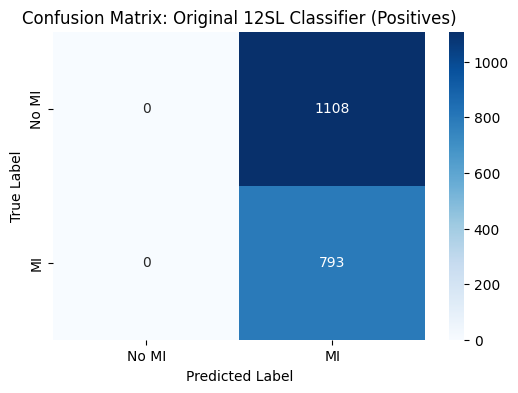

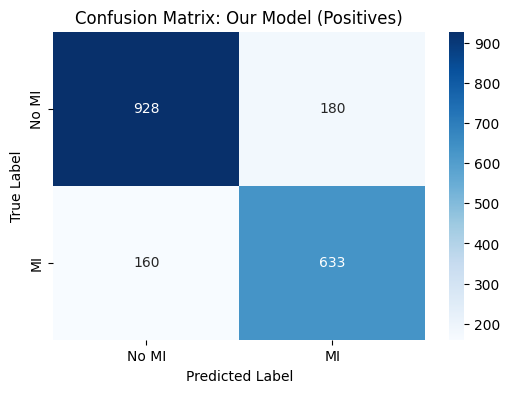

In [58]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#confusion matrix 12SL (no model)

cm = confusion_matrix(y_test_pos, y_12SL_pos)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Original 12SL Classifier (Positives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#confusion matrix (from model)

cm = confusion_matrix(y_test_pos, y_pred_pos)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Our Model (Positives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Baseline Sensitivity (Recall): 1.0
Baseline Precision (PPV): 0.4171488690163072
Model Sensitivity (Recall): 0.798234552332913
Model Precision (PPV): 0.7785977859778598


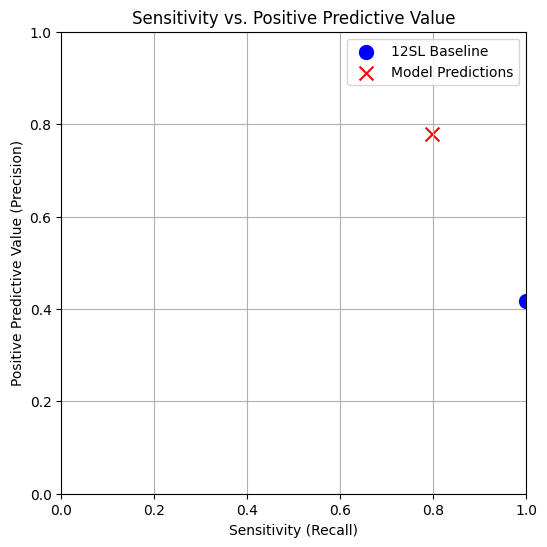

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

y_true = y_test_pos  # Ground truth for positive subset
baseline_pred = y_12SL.loc[y_test_pos.index]  # 12SL classifier predictions for the same subset
model_pred = y_pred_pos  # Predictions from your trained model

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

sensitivity_model = recall_score(y_true, model_pred)
precision_model = precision_score(y_true, model_pred)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Model Sensitivity (Recall):", sensitivity_model)
print("Model Precision (PPV):", precision_model)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='12SL Baseline', color='blue', marker='o', s=100)
plt.scatter(sensitivity_model, precision_model, 
            label='Model Predictions', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. Positive Predictive Value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


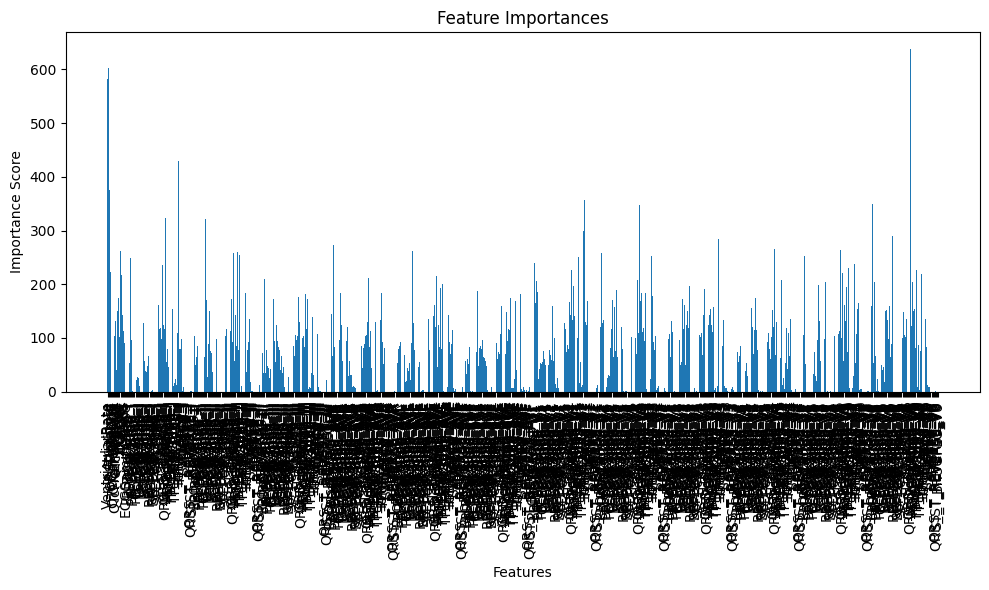

In [60]:
import matplotlib.pyplot as plt
import numpy as np

importances = model_pos.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


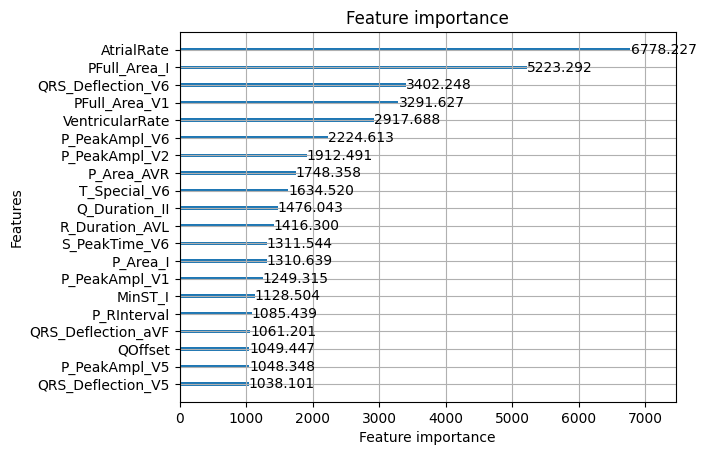

In [61]:
booster = model_pos.booster_
importances = booster.feature_importance(importance_type='split')
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


In [62]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

X = X_train_pos
y = y_train_pos

# Hyperparameter search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
}

def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        objective='binary',
        # metric='auc',
        verbose=-1,
        **params
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X, y, scoring='f1', cv=cv).mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  
    trials=trials,
    rstate=np.random.Generator(np.random.PCG64(42))
)

print("Best hyperparameters:", best)


100%|██████████| 100/100 [5:04:33<00:00, 182.73s/trial, best loss: 0.19111737753261482] 
Best hyperparameters: {'boosting_type': np.int64(1), 'colsample_bytree': np.float64(0.8621991808512985), 'learning_rate': np.float64(0.17072289129286586), 'max_depth': np.float64(9.0), 'min_child_weight': np.float64(3.0), 'num_leaves': np.float64(69.0), 'reg_alpha': np.float64(0.2958433230465372), 'reg_lambda': np.float64(0.5468240713095661), 'scale_pos_weight': np.float64(3.2254318501522548), 'subsample': np.float64(0.8596836202805724)}


In [ ]:
#run model with the parameters from the dictionary with the model parameters from "best"

lgb_params = {
    'objective': 'binary',
    'boosting_type': best['boosting_type'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': best['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(best['num_leaves']),
    'min_child_weight': int(best['min_child_weight']),
    'max_depth' : int(best['max_depth']),
    'reg_alpha' : best['reg_alpha'],
    'reg_lambda' : best['reg_lambda'],
    'subsample' : best['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': best['scale_pos_weight'],
    }

model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)

Number of components selected: 277
Total variance explained: 0.9501401527639176
Principal components shape: (61047, 277)


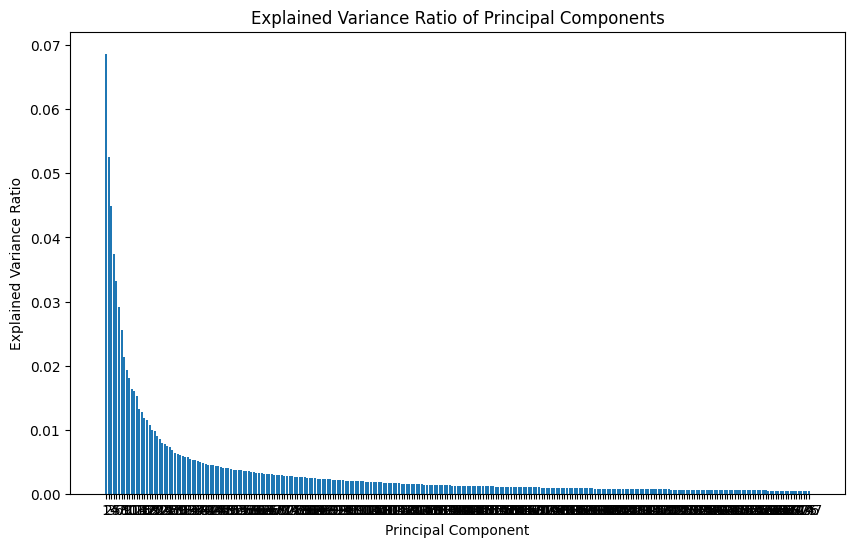

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cols = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys'])
# drop NaN values
df_cols = df_cols.dropna()
X_scaled = scaler.fit_transform(df_cols)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% of variance
principal_components = pca.fit_transform(X_scaled)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())
print("Principal components shape:", principal_components.shape)
#column names from original data
feature_names = df_cols.columns

# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()

In [64]:
estimators = [0.2, 0.15, 0.11, 0.1, 0.09, 0.08, 0.07, 0.025, 0.01, 0.005]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 50,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            'scale_pos_weight': 10,
            }
        model_neg = (lgb.LGBMClassifier(**lgb_params))
        model_neg.fit(X_train_neg, y_train_neg)
        y_pred_neg = model_neg.predict(X_test_neg)
        score = f1_score(y_test_neg, y_pred_neg, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

Learning rate: 0.2, Number of Leaves: 15 F1 score: 0.8938
Learning rate: 0.2, Number of Leaves: 31 F1 score: 0.9134
Learning rate: 0.2, Number of Leaves: 63 F1 score: 0.9338
Learning rate: 0.2, Number of Leaves: 127 F1 score: 0.9456
Learning rate: 0.15, Number of Leaves: 15 F1 score: 0.8928
Learning rate: 0.15, Number of Leaves: 31 F1 score: 0.9056
Learning rate: 0.15, Number of Leaves: 63 F1 score: 0.9292
Learning rate: 0.15, Number of Leaves: 127 F1 score: 0.9429
Learning rate: 0.11, Number of Leaves: 15 F1 score: 0.8883
Learning rate: 0.11, Number of Leaves: 31 F1 score: 0.9033
Learning rate: 0.11, Number of Leaves: 63 F1 score: 0.9210
Learning rate: 0.11, Number of Leaves: 127 F1 score: 0.9389
Learning rate: 0.1, Number of Leaves: 15 F1 score: 0.8881
Learning rate: 0.1, Number of Leaves: 31 F1 score: 0.8977
Learning rate: 0.1, Number of Leaves: 63 F1 score: 0.9190
Learning rate: 0.1, Number of Leaves: 127 F1 score: 0.9368
Learning rate: 0.09, Number of Leaves: 15 F1 score: 0.8863
L

In [65]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.1,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 10,
    }
model_neg = (lgb.LGBMClassifier(**lgb_params))
model_neg.fit(X_train_neg, y_train_neg)
y_pred_neg = model_neg.predict(X_test_neg)
score = f1_score(y_test_neg, y_pred_neg, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.9564255695642557


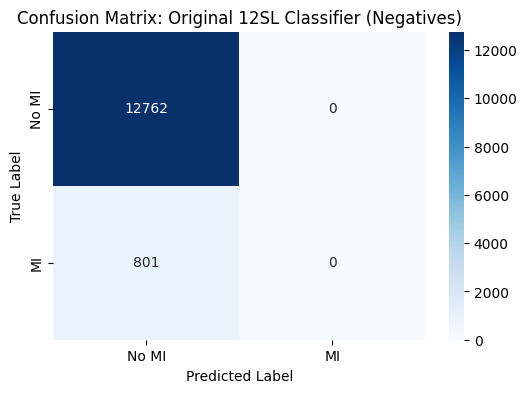

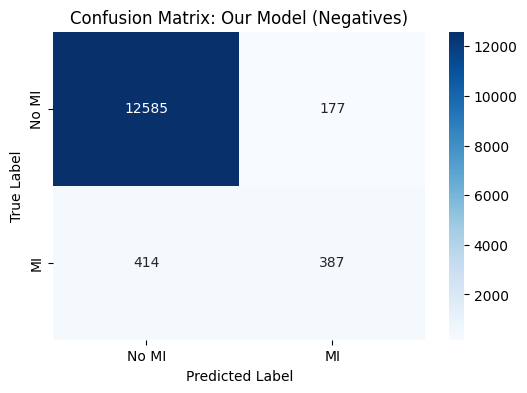

In [66]:
#confusion matrix 12SL (no model)

cm = confusion_matrix(y_test_neg, y_12SL_neg)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Original 12SL Classifier (Negatives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#confusion matrix (from model)

cm = confusion_matrix(y_test_neg, y_pred_neg)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No MI", "MI"], yticklabels=["No MI", "MI"])
plt.title("Confusion Matrix: Our Model (Negatives)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Baseline Sensitivity (Recall): 0.0
Baseline Precision (PPV): 0.0
Model Sensitivity (Recall): 0.48314606741573035
Model Precision (PPV): 0.6861702127659575


c:\Users\sbrad\Downloads\CS620-DCAR\stroke-of-luck\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


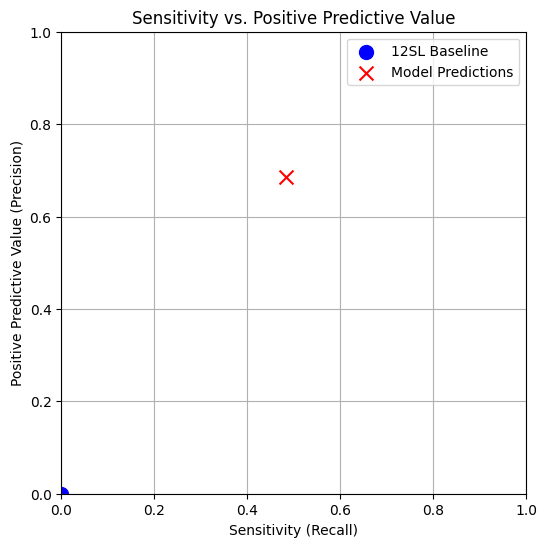

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

y_true = y_test_neg  # Ground truth for positive subset
baseline_pred = y_12SL.loc[y_test_neg.index]  # 12SL classifier predictions for the same subset
model_pred = y_pred_neg  # Predictions from your trained model

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

sensitivity_model = recall_score(y_true, model_pred)
precision_model = precision_score(y_true, model_pred)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Model Sensitivity (Recall):", sensitivity_model)
print("Model Precision (PPV):", precision_model)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='12SL Baseline', color='blue', marker='o', s=100)
plt.scatter(sensitivity_model, precision_model, 
            label='Model Predictions', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. Positive Predictive Value')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


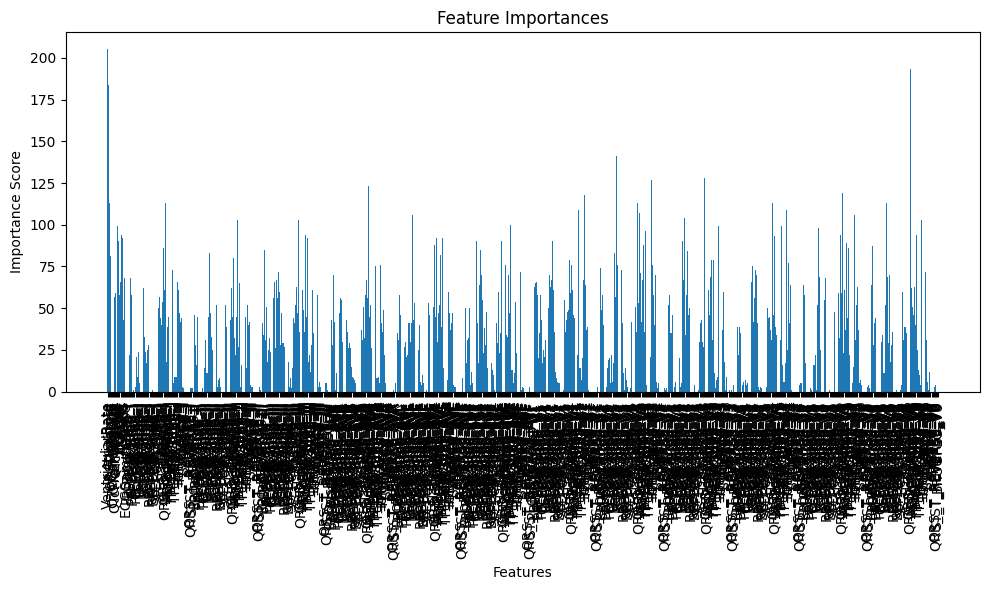

In [68]:
importances = model_neg.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


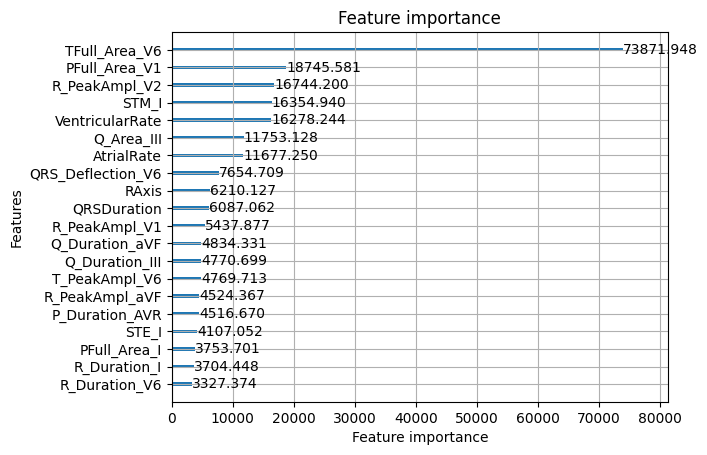

In [69]:
booster = model_neg.booster_
importances = booster.feature_importance(importance_type='split')
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Baseline Sensitivity (Recall): 0.4974905897114178
Baseline Precision (PPV): 0.4171488690163072
Combined Model Sensitivity (Recall): 0.6398996235884568
Combined Model Precision (PPV): 0.7407407407407407


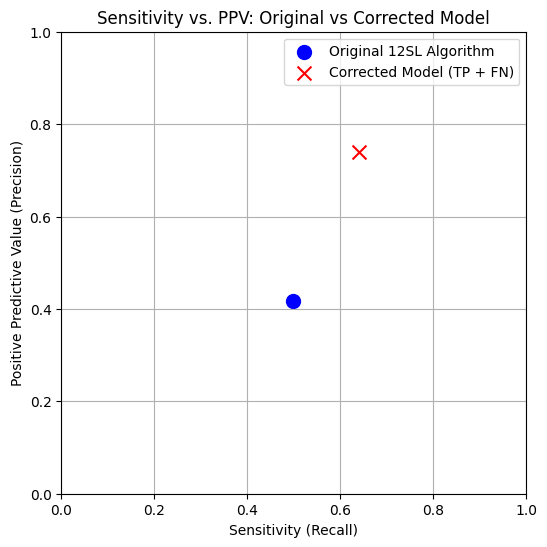

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

#Compute performance for the original algorithm (MI_12SL)
y_true = y_test
baseline_pred = y_12SL 

sensitivity_baseline = recall_score(y_true, baseline_pred)
precision_baseline = precision_score(y_true, baseline_pred)

#Generate Combined Model Predictions
y_pred_pos = model_pos.predict(X_test_pos)
y_pred_neg = model_neg.predict(X_test_neg)

# Merge the corrected predictions into a single output
y_pred_combined = y_12SL.copy()  # original MI_12SL predictions
y_pred_combined.loc[X_test_pos.index] = y_pred_pos  # Replace with TP model results
y_pred_combined.loc[X_test_neg.index] = y_pred_neg  # Replace with FN model results

#Compute performance for the Combined Model
sensitivity_combined = recall_score(y_true, y_pred_combined)
precision_combined = precision_score(y_true, y_pred_combined)

print("Baseline Sensitivity (Recall):", sensitivity_baseline)
print("Baseline Precision (PPV):", precision_baseline)
print("Combined Model Sensitivity (Recall):", sensitivity_combined)
print("Combined Model Precision (PPV):", precision_combined)

plt.figure(figsize=(6,6))
plt.scatter(sensitivity_baseline, precision_baseline, 
            label='Original 12SL Algorithm', color='blue', marker='o', s=100)
plt.scatter(sensitivity_combined, precision_combined, 
            label='Corrected Model (TP + FN)', color='red', marker='x', s=100)

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Sensitivity vs. PPV: Original vs Corrected Model')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


In [71]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

X = X_train_neg
y = y_train_neg

# Hyperparameter search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
}

def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        objective='binary',
        # metric='auc',
        verbose=-1,
        **params
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X, y, scoring='f1', cv=cv).mean()
    
    return {'loss': 1 - score, 'status': STATUS_OK}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  
    trials=trials,
    rstate=np.random.Generator(np.random.PCG64(42))
)

print("Best hyperparameters:", best)


 98%|█████████▊| 98/100 [105:47:05<2:09:31, 3885.98s/trial, best loss: 0.4502277543870117] 


KeyboardInterrupt: 

In [ ]:
#run model with the parameters from the dictionary with the model parameters from "best"

lgb_params = {
    'objective': 'binary',
    'boosting_type': best['boosting_type'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': 1000,
    'learning_rate': best['learning_rate'],
    'random_state': 42,
    'verbose': -1,
    'num_leaves': int(best['num_leaves']),
    'min_child_weight': int(best['min_child_weight']),
    'max_depth' : int(best['max_depth']),
    'reg_alpha' : best['reg_alpha'],
    'reg_lambda' : best['reg_lambda'],
    'subsample' : best['subsample'],
    # 'metric': 'auc', 
    'scale_pos_weight': best['scale_pos_weight'],
    }

model_pos = (lgb.LGBMClassifier(**lgb_params))
model_pos.fit(X_train_pos, y_train_pos)
y_pred_pos = model_pos.predict(X_test_pos)
score = f1_score(y_test_pos, y_pred_pos, average='micro')
print("Final F1 score: ", score)